### Accuracy of positions from accelerometer sensors, the necessity of virtual experiments with sensors

We begin with one dimensional 
synthetic position data recorded at 0.1milisecond intervals
describing the motion of an object at rest to a position 0.14m 
along the X-axis and back again within a 2 second burst.  

The position data is smooth and fine enough to derive 
velocity and acceleration graphs from it (max velocity is 
0.40m/s and max acceleration is 2.78m/s^2).

We conduct a variety of simulated sampling rates on this 
derived acceleration data and then apply noise and limited 
precision to the numbers before attempting to reconstruct 
the velocity and position of the object from this realistic data.

By running simulations of measurements against the synthetic 
data many times under different conditions (eg sampling phase 
and noise) we create a baseline for the statistical 
accuracy based the properties of the sensor.  

This method of simulating the proposed sensors against 
a set of synthetic data provides for a more systematic 
and informed deployment of sensors and 
interprative algorithms in any motion capture 
experiment.

It should be standard practice to have realistic synthetic 
data -- at a far higher resolution that could ever be captured 
in the real world -- as a base line stimulus for these 
virtual experiments.  This must an integral step in the design, 
before any hardware is commissioned or fitted to an 
experimental subject, and it would avoid researchers getting 
ahead of themselves just to collect some numerical data 
which turned out not to be useful.  

There are advantages to establishing a critical eye 
on the potential data before there has been an 
investment in collecting it, as negative comments about it 
afterward the work has been done tends to offend.






### To do
Also pin down tail to constant velocity and measure 
peak height, if this is the data that is required 
(not necessarily the absolute position at any time)


In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [117]:
import pandas, numpy
from syntheticdata import px

px["v"] = (px.x.diff()/px.t.diff()).shift(-1)
px["a"] = (px.v.diff()/px.t.diff()).shift(-1)
px = px.dropna()
px.head()

,t,x,v,a
0,0.0000,-5.625416e-18,1.125083e-13,-1.687625e-09
1,0.0001,5.625416e-18,-5.625416e-14,2.250166e-09
2,0.0002,0.000000e+00,1.687625e-13,-3.937791e-09
3,0.0003,1.687625e-17,-2.250166e-13,-1.514613e-24
4,0.0004,-5.625416e-18,-2.250166e-13,6.750499e-09


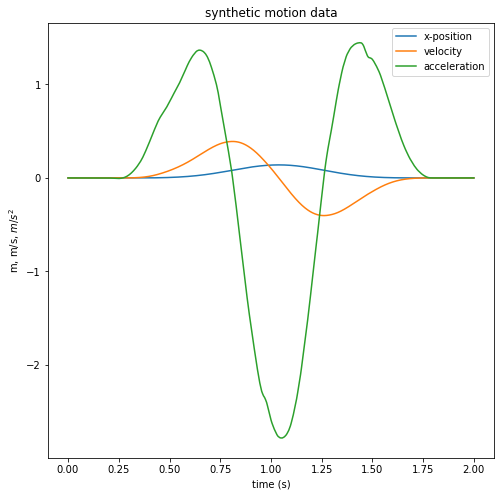

In [16]:
# derive velocity and acceleration from synthetic data

plt.figure(figsize=(8,8))
plt.plot(px.t, px.x, label="x-position")
plt.plot(px.t, px.v, label="velocity")
plt.plot(px.t, px.a, label="acceleration")
plt.xlabel("time (s)")
plt.ylabel("m, m/s, $m/s^2$")
plt.title("synthetic motion data")
plt.legend();


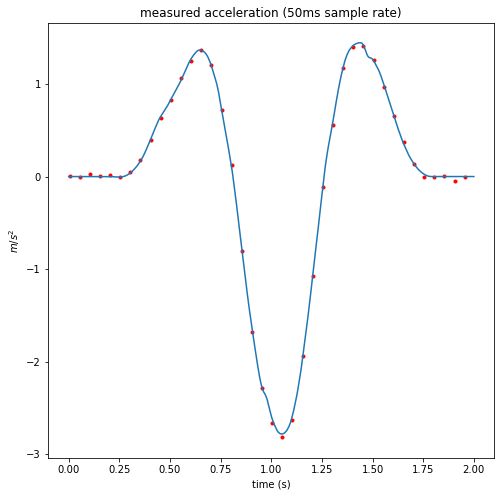

In [15]:
# This gets a series of acceleration samples from the motion at a precision
# acceleration is in m/s^2.  The BNO055 accelerometer measures to 0.01m/s^2
import random
def samplecurve(subsamplerate, startsample, noisestd, precision):
    spx = px.iloc[list(range(startsample, len(px), subsamplerate))]
    ts = list(spx.t)
    accs = [ round(random.gauss(a, noisestd)/precision)*precision  for a in spx.a ]
    return pandas.DataFrame({"t":ts, "a":accs})

plt.figure(figsize=(8,8))
subsamplerate = 500
sacc = samplecurve(subsamplerate=subsamplerate, startsample=45, noisestd=0.02, precision=0.01)
plt.plot(px.t, px.a)
plt.scatter(sacc.t, sacc.a, marker=".", color="r")
plt.xlabel("time (s)")
plt.ylabel("$m/s^2$")
plt.title("measured acceleration (%dms sample rate)" % int(0.1*subsamplerate));

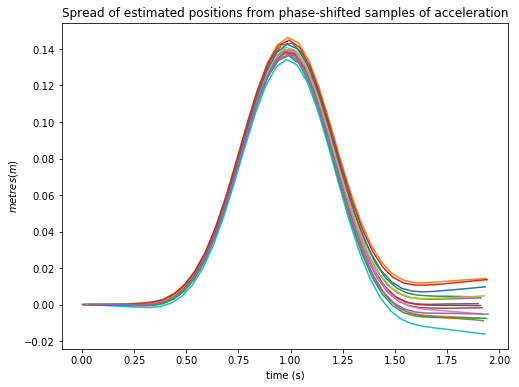

In [116]:
# Now consider the same data but with many different 
# sampling phases with sensor noise added
plt.figure(figsize=(8,6))
subsamplerate = 500
for startsample in range(10, subsamplerate, 33):
    sacc = samplecurve(subsamplerate=subsamplerate, startsample=startsample, noisestd=0.02, precision=0.01)
    sacc["v"] = (sacc.a*sacc.t.diff().shift(-1)).cumsum()
    sacc["x"] = (sacc.v*sacc.t.diff().shift(-1)).cumsum()
    plt.plot(sacc.t, sacc.x)
plt.title("Spread of estimated positions from phase-shifted samples of acceleration")
plt.xlabel("time (s)")
plt.ylabel("$metres (m)$")
None

In [67]:
numpy.random.uniform(10, 20, 5)

array([ 10.43324063,  15.6143308 ,  13.29668446,  15.02966833,  11.11894318])

Mean 0.000389 std 0.0183365753755


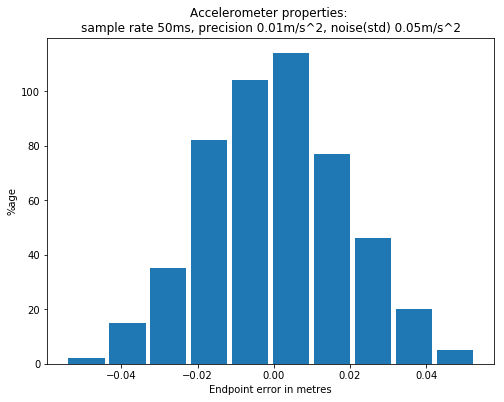

In [71]:
plt.figure(figsize=(8,6))
subsamplerate = 500
noisestd = 0.05
precision = 0.01
def getxends(subsamplerate, noisestd, precision, nsamples):
    xends = [ ]
    for startsample in numpy.random.uniform(0, subsamplerate, nsamples):
        sacc = samplecurve(subsamplerate=subsamplerate, startsample=int(startsample), noisestd=noisestd, precision=precision)
        sacc["v"] = (sacc.a*sacc.t.diff().shift(-1)).cumsum()
        sacc["x"] = (sacc.v*sacc.t.diff().shift(-1)).cumsum()
        xends.append(sacc.x.iloc[-2])
    return numpy.array(xends)
    
xends = getxends(subsamplerate, noisestd, precision, 500)
plt.hist(xends, rwidth=0.9)
plt.title("Accelerometer properties: \nsample rate %dms, precision %.02fm/s^2, noise(std) %0.02fm/s^2" % (int(0.1*subsamplerate), precision, noisestd))
plt.ylabel("%age")
plt.xlabel("Endpoint error in metres");
print("Mean", xends.mean(), "std", xends.std())

In [72]:
# Generate the lists of errors from different noise
noisestds = numpy.linspace(0, 0.05, 6)
xendsmeans = [ ]
xendsstds = [ ]
nsamples = 100
xendslist = [ ]
for noisestd in noisestds:
    xends = getxends(subsamplerate=500, noisestd=noisestd, precision=0.01, nsamples=nsamples)
    xendslist.append(xends)


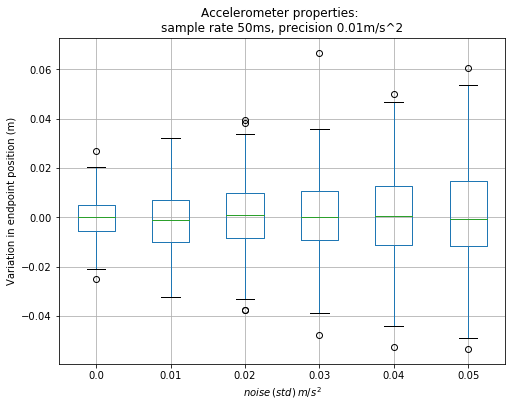

In [112]:
plt.figure(figsize=(8,6))
df = pandas.DataFrame(data=xendslist).transpose()
df.columns = noisestds
boxplot = df.boxplot()
plt.xlabel("$noise\\:(std)\\:m/s^2$")  # latex mode for ^2 (square) symbol
plt.ylabel("Variation in endpoint position (m)")
plt.title("Accelerometer properties: \nsample rate %dms, precision %.02fm/s^2" % (int(0.1*subsamplerate), precision))
None

In [100]:
# Generate the lists of errors from different sample rates
samplemss = numpy.linspace(10, 60, 6)
nsamples = 500
noisestd = 0.05
xendslist = [ ]
for samplems in samplemss:
    xends = getxends(subsamplerate=int(samplems/0.1), noisestd=noisestd, precision=0.01, nsamples=nsamples)
    xendslist.append(xends)


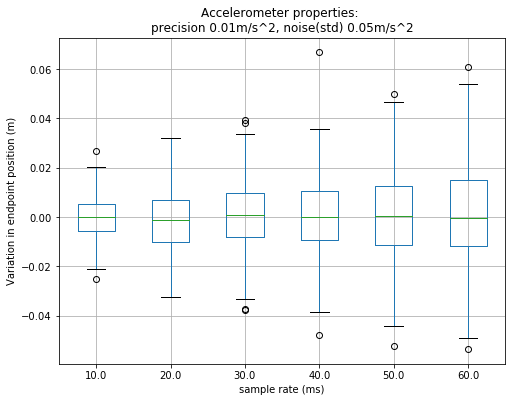

In [113]:
plt.figure(figsize=(8,6))
df = pandas.DataFrame(data=xendslist).transpose()
df.columns = samplemss
boxplot = df.boxplot()
plt.xlabel("sample rate (ms)")
plt.ylabel("Variation in endpoint position (m)")
plt.title("Accelerometer properties: \nprecision %.02fm/s^2, noise(std) %0.02fm/s^2" % (0.01, noisestd))
None

In [ ]:
# 